In [2]:
import pandas as pd
import numpy as np
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBM
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

from baseline_prism_iii import prism_iii, get_prism_iii_feats

import warnings
warnings.filterwarnings('ignore') 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.rcParams['pdf.fonttype'] = 42
    

In [3]:
def my_eval(gt, y_pred_proba):
    """
    y_pred_proba are float
    gt, y_pred are binary
    """
    
    ret = OrderedDict({})
    ret['auroc'] = roc_auc_score(gt, y_pred_proba)
    ret['auprc'] = average_precision_score(gt, y_pred_proba)
    ret['fpr'], ret['tpr'], _ = roc_curve(gt, y_pred_proba)
    ret['precision'], ret['recall'], _ = precision_recall_curve(gt, y_pred_proba)

    return ret

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def print_lr_model(m, x_cols):
    
    final_m_coef_ = m.coef_[0]
    final_m_intercept_ = m.intercept_[0]
    model_str = ''
    for i in range(len(x_cols)):
        model_str += '{:.4f}*{} + '.format(final_m_coef_[i], x_cols[i])
    model_str += '{:.4f}'.format(final_m_intercept_)
    model_str = 'sigmoid(' + model_str + ')'
    print('Probability =', model_str)
    
def median_imputation(X, X_test):
    x_commons = np.nanmedian(X, axis=0)
    for i in range(X.shape[1]):
        X[:,i][np.isnan(X[:,i])] = x_commons[i]
        X_test[:,i][np.isnan(X_test[:,i])] = x_commons[i]
    return X, X_test
    

In [4]:
seed = 0
n_fold = 10
max_n_features = 64


# 1 Read data

In [5]:
np.random.seed(seed)
df = pd.read_csv('icu_first24hours.csv')
print('Read data shape:', df.shape)

prism_iii_feats = get_prism_iii_feats()
# remove columns with more than MAX_MISSING_RATE
MAX_MISSING_RATE = 0.9 # to use all features, set 1.0
df_missing_rate = df.isnull().mean().sort_values().reset_index()
df_missing_rate.columns = ['col','missing_rate']
cols = list(df_missing_rate[df_missing_rate['missing_rate'] < MAX_MISSING_RATE].col.values)
cols = sorted(list(set(cols) | set(prism_iii_feats)))
df = df[cols]
print('Removing high missing rate, data shape:', df.shape)

# data split
shuffle_idx = np.random.permutation(df.shape[0])
split_idx = int(0.8*df.shape[0])
train_idx = shuffle_idx[:split_idx]
test_idx = shuffle_idx[split_idx:]
print('data split check value should be {} (should be 70497652)'.format(np.sum(train_idx)))
df_test = df.iloc[test_idx]
df = df.iloc[train_idx]
print('train/val set: ', df.shape, '; test set: ', df_test.shape)

# convert to numpy array
x_cols_all = sorted(set(cols) - set(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'HOSPITAL_EXPIRE_FLAG', 'is_early_death']))
X = df[x_cols_all].values
X_test = df_test[x_cols_all].values
print('# of missing values before imputation:', np.sum(np.isnan(X)), np.sum(np.isnan(X_test)))
X, X_test = median_imputation(X, X_test) # imputation
print('# of missing values before imputation:', np.sum(np.isnan(X)), np.sum(np.isnan(X_test)))
y = df['HOSPITAL_EXPIRE_FLAG'].values
y_test = df_test['HOSPITAL_EXPIRE_FLAG'].values


Read data shape: (13258, 1667)
Removing high missing rate, data shape: (13258, 402)
data split check value should be 70497652 (should be 70497652)
train/val set:  (10606, 402) ; test set:  (2652, 402)
# of missing values before imputation: 1931055 487753
# of missing values before imputation: 0 0


# 2 Demographic stat

30.24495568546106
44.35270367967397
Counter({1: 6081, 0: 4525}) 0.4266452951159721
Counter({0: 9976, 1: 630}) 0.05940033943051103
28.966440422322776
42.71286861413018
Counter({1: 1535, 0: 1117}) 0.4211915535444947
Counter({0: 2502, 1: 150}) 0.05656108597285068


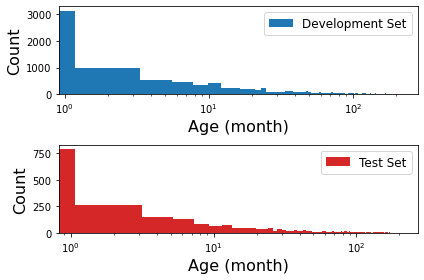

In [6]:
print(np.mean(df.age_month))
print(np.std(df.age_month))
print(Counter(df.gender_is_male), Counter(df.gender_is_male)[0]/df.shape[0])
print(Counter(df.HOSPITAL_EXPIRE_FLAG), Counter(df.HOSPITAL_EXPIRE_FLAG)[1]/df.shape[0])

print(np.mean(df_test.age_month))
print(np.std(df_test.age_month))
print(Counter(df_test.gender_is_male), Counter(df_test.gender_is_male)[0]/df_test.shape[0])
print(Counter(df_test.HOSPITAL_EXPIRE_FLAG), Counter(df_test.HOSPITAL_EXPIRE_FLAG)[1]/df_test.shape[0])

age1 = df.age_month
age2 = df_test.age_month
fig, ax = plt.subplots(2,1, figsize=(6,4))
ax[0].hist(age1, bins=100, color='tab:blue')
ax[0].legend(['Development Set'], fontsize=12)
ax[0].set_xlabel('Age (month)', fontsize=16)
ax[0].set_ylabel('Count', fontsize=16)
ax[0].set_xscale('log')
ax[1].hist(age2, bins=100, color='tab:red')
ax[1].legend(['Test Set'], fontsize=12)
ax[1].set_xlabel('Age (month)', fontsize=16)
ax[1].set_ylabel('Count', fontsize=16)
ax[1].set_xscale('log')
plt.tight_layout()
plt.savefig('img/age.pdf')


# 3 Rank all features

In [ ]:
print('Rank all feats by complex tree model ...')
kf = KFold(n_splits=n_fold, shuffle=True, random_state=seed)
feature_scores = []
for train_index, val_index in tqdm(kf.split(X), desc='Ranking...'):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # RF or GBM
#     m = RF(n_estimators=100, random_state=seed)
    m = GBM(n_estimators=100, random_state=seed, max_depth=100) # GBM is slower
    m.fit(X_train, y_train)
    feature_scores.append(m.feature_importances_)

feature_scores = np.mean(np.array(feature_scores), axis=0)
df_imp = pd.DataFrame({'col':x_cols_all, 'score':feature_scores})
df_imp = df_imp.merge(df_missing_rate, left_on='col', right_on='col', how='left')
df_imp = df_imp.sort_values(by='score', ascending=False)
df_imp.to_csv('importance_scores.csv', index=False)


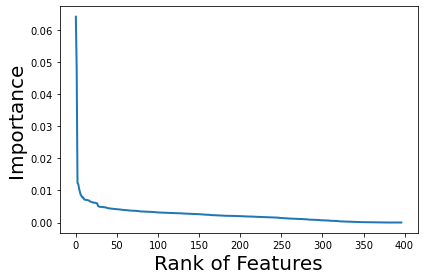

In [17]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
ax.plot(df_imp.score.values, color='tab:blue', linewidth=2)
ax.set_xlabel('Rank of Features', fontsize=20)
ax.set_ylabel('Importance', fontsize=20)
# ax.set_yscale('log')
plt.tight_layout()
plt.savefig('img/ranking.pdf')

# 4 Step-wise evaluating features by cross validation

In [9]:
df_imp = pd.read_csv('importance_scores.csv') # uncomment if you already computed the importance_scores

print('Evaluating top feats by cross validation ...')
n_features = list(range(1,max_n_features+1))
all_res = []
for topK in tqdm(n_features, desc='Evaluating'):
    tmp_res = []
    x_cols = df_imp[:topK].col.values
    X = np.nan_to_num(df[x_cols].values)
    X_test = np.nan_to_num(df_test[x_cols].values)
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=seed)
    for train_index, val_index in kf.split(X):

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        m = LR(class_weight='balanced')
        m.fit(X_train, y_train)
        y_pred = m.predict_proba(X_val)[:,1]
        t_res = my_eval(y_val, y_pred)
        tmp_res.append([t_res['auroc'], t_res['auprc']])

    all_res.append(tmp_res)

all_res = np.array(all_res)
res_mean = np.mean(all_res, axis=1)
res_std = np.std(all_res, axis=1)
res_df = pd.DataFrame(np.stack([np.array(n_features).T, res_mean[:,0], res_mean[:,1], res_std[:,0], res_std[:,1]], axis=1))
res_df.columns = ['topK', 'AUROC_mean', 'AUPRC_mean', 'AUROC_std', 'AUPRC_std']


Evaluating:   2%|▏         | 1/64 [00:00<00:09,  6.31it/s]

Evaluating top feats by cross validation ...


Evaluating: 100%|██████████| 64/64 [00:45<00:00,  1.41it/s]


59


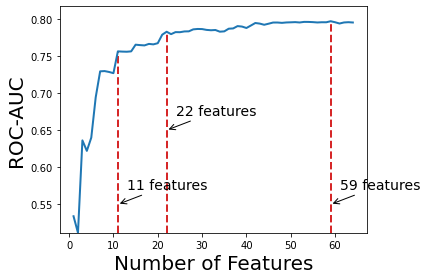

In [10]:

topK = 59 # Set by experiment
topK1 = 11 # Set by experiment
topK2 = 22 # Set by experiment

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
plt.xlabel('Number of Features')
plt.ylabel('ROC-AUC')
ax.plot(list(range(1,max_n_features+1)), res_df.AUROC_mean.values, color='tab:blue', linewidth=2)
ax.set_xlabel('Number of Features', fontsize=20)
ax.set_ylabel('ROC-AUC', fontsize=20)
max_x = np.argmax(res_df.AUROC_mean)+1
max_y = res_df.AUROC_mean.values[max_x]
print(max_x)
ax.vlines(max_x, np.min(res_df.AUROC_mean.values), max_y, linestyle='dashed', color='tab:red', linewidth=2)
ax.vlines(topK1, np.min(res_df.AUROC_mean.values), res_df.AUROC_mean.values[topK1-1], linestyle='dashed', color='tab:red', linewidth=2)
ax.vlines(topK2, np.min(res_df.AUROC_mean.values), res_df.AUROC_mean.values[topK2-1], linestyle='dashed', color='tab:red', linewidth=2)
ax.set_ylim([np.min(res_df.AUROC_mean.values), np.max(res_df.AUROC_mean.values)+0.02])
ax.annotate('{} features'.format(topK), (topK, 0.55), xytext=(topK+2,0.57), fontsize=14, arrowprops={'arrowstyle':'->'})
ax.annotate('{} features'.format(topK1), (topK1, 0.55), xytext=(topK1+2,0.57), fontsize=14, arrowprops={'arrowstyle':'->'})
ax.annotate('{} features'.format(topK2), (topK2, 0.65), xytext=(topK2+2,0.67), fontsize=14, arrowprops={'arrowstyle':'->'})
plt.tight_layout()
plt.savefig('img/stepwise.pdf')


# 5 Choose final model

Final model ...
Best features: 59
Minimal features: 11
Medium features: 22
Probability = sigmoid(0.0012*age_month + -0.3858*lab_5237_min + 0.0496*lab_5213_max + 0.0016*chart_1004_max + 0.1023*lab_5227_min + 0.0320*lab_5225_range + 0.0229*lab_5235_max + -0.0038*lab_5236_min + -0.0090*lab_5257_min + 0.0434*lab_6473_min + 0.1049*lab_5136_min + -0.0470)
Probability = sigmoid(0.0021*age_month + -0.0330*lab_5237_min + 0.0424*lab_5213_max + 0.0013*chart_1004_max + 0.0195*lab_5227_min + 0.0161*lab_5225_range + 0.0234*lab_5235_max + -0.0035*lab_5236_min + -0.0082*lab_5257_min + 0.0307*lab_6473_min + 0.0507*lab_5136_min + 0.0012*lab_5239_max + 0.0319*lab_5136_max + -0.0214*lab_5215_max + -0.0370*weight_kg + -0.0052*lab_5094_min + 0.0142*lab_6473_max + -0.0229*lab_5127_max + -0.0017*lab_5141_max + 0.1516*lab_5128_min + -0.1226*chart_1001_min + 0.0729*lab_5227_max + -0.0037)
Probability = sigmoid(0.0002*age_month + -0.0002*lab_5237_min + 0.0175*lab_5213_max + 0.0010*chart_1004_max + 0.0087*lab_522

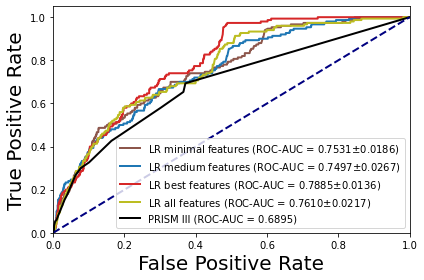

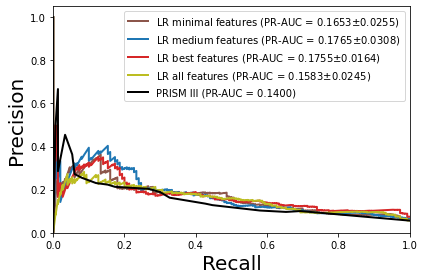

In [11]:
def bootstrap_LR(X, Y, X_test, y_test, x_cols, n=20, r=0.9, print_model=False):
    auroc_list = []
    auprc_list = []
    m = LR(class_weight='balanced')
    m.fit(X, y)
    if print_model:
        print_lr_model(m, x_cols)
    y_pred = m.predict_proba(X_test)[:,1]
    final_res_all = my_eval(y_test, y_pred)    
    for i in range(n):
        n_samples = X_test.shape[0]
        random_indices = np.random.choice(n_samples, int(r*n_samples), replace=True)
        X_test_sub = X_test[random_indices]
        y_test_sub = y_test[random_indices]
        y_pred_sub = m.predict_proba(X_test_sub)[:,1]
        final_res = my_eval(y_test_sub, y_pred_sub)
        auroc_list.append(final_res['auroc'])
        auprc_list.append(final_res['auprc'])
    final_res_all['auroc_std'] = np.std(auroc_list)
    final_res_all['auprc_std'] = np.std(auprc_list)
    return final_res_all

topK = 59 # Set by experiment
topK1 = 11 # Set by experiment
topK2 = 22 # Set by experiment

df_imp = pd.read_csv('importance_scores.csv') # uncomment if you already computed the importance_scores

print('Final model ...')

x_cols = list(df_imp[:topK].col.values)
print('Best features: {}'.format(topK))
x_cols1 = list(df_imp[:topK1].col.values)
print('Minimal features: {}'.format(topK1))
x_cols2 = list(df_imp[:topK2].col.values)
print('Medium features: {}'.format(topK2))

X, X_test = median_imputation(df[x_cols].values, df_test[x_cols].values) # imputation
X1, X_test1 = median_imputation(df[x_cols1].values, df_test[x_cols1].values) # imputation
X2, X_test2 = median_imputation(df[x_cols2].values, df_test[x_cols2].values) # imputation
X_all, X_test_all = median_imputation(df[x_cols_all].values, df_test[x_cols_all].values) # imputation

final_res_lr1 = bootstrap_LR(X1, y, X_test1, y_test, x_cols1, print_model=True) # LR minimal
final_res_lr2 = bootstrap_LR(X2, y, X_test2, y_test, x_cols2, print_model=True) # LR medium
final_res_lr = bootstrap_LR(X, y, X_test, y_test, x_cols, print_model=True) # LR best
final_res_lr_all = bootstrap_LR(X_all, y, X_test_all, y_test, x_cols_all) # LR best

# baseline prism_iii
y_pred_prism_iii = prism_iii(df_test)
final_res_prism_iii = my_eval(y_test, y_pred_prism_iii)

# plot
plt.figure(figsize=(6,4))
lw = 2
plt.plot(final_res_lr1['fpr'], final_res_lr1['tpr'], color='tab:brown', lw=lw, label='LR minimal features (ROC-AUC = {0:0.4f}$\pm${1:0.4f})'.format(final_res_lr1['auroc'], final_res_lr1['auroc_std']))
plt.plot(final_res_lr2['fpr'], final_res_lr2['tpr'], color='tab:blue', lw=lw, label='LR medium features (ROC-AUC = {0:0.4f}$\pm${1:0.4f})'.format(final_res_lr2['auroc'], final_res_lr2['auroc_std']))
plt.plot(final_res_lr['fpr'], final_res_lr['tpr'], color='tab:red', lw=lw, label='LR best features (ROC-AUC = {0:0.4f}$\pm${1:0.4f})'.format(final_res_lr['auroc'], final_res_lr['auroc_std']))
plt.plot(final_res_lr_all['fpr'], final_res_lr_all['tpr'], color='tab:olive', lw=lw, label='LR all features (ROC-AUC = {0:0.4f}$\pm${1:0.4f})'.format(final_res_lr_all['auroc'], final_res_lr_all['auroc_std']))
plt.plot(final_res_prism_iii['fpr'], final_res_prism_iii['tpr'], color='k', lw=lw, label='PRISM III (ROC-AUC = %0.4f)' % final_res_prism_iii['auroc'])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.savefig('img/roc.pdf')


# plot
plt.figure(figsize=(6,4))
lw = 2
plt.plot(final_res_lr1['recall'], final_res_lr1['precision'], color='tab:brown', lw=lw, label='LR minimal features (PR-AUC = {0:0.4f}$\pm${1:0.4f})'.format(final_res_lr1['auprc'], final_res_lr1['auprc_std']))
plt.plot(final_res_lr2['recall'], final_res_lr2['precision'], color='tab:blue', lw=lw, label='LR medium features (PR-AUC = {0:0.4f}$\pm${1:0.4f})'.format(final_res_lr2['auprc'], final_res_lr2['auprc_std']))
plt.plot(final_res_lr['recall'], final_res_lr['precision'], color='tab:red', lw=lw, label='LR best features (PR-AUC = {0:0.4f}$\pm${1:0.4f})'.format(final_res_lr['auprc'], final_res_lr['auprc_std']))
plt.plot(final_res_lr_all['recall'], final_res_lr_all['precision'], color='tab:olive', lw=lw, label='LR all features (PR-AUC = {0:0.4f}$\pm${1:0.4f})'.format(final_res_lr_all['auprc'], final_res_lr_all['auprc_std']))
plt.plot(final_res_prism_iii['recall'], final_res_prism_iii['precision'], color='k', lw=lw, label='PRISM III (PR-AUC = %0.4f)' % final_res_prism_iii['auprc'])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.legend(loc="top right", fontsize=10)
plt.tight_layout()
plt.savefig('img/pr.pdf')

# Supplement: Compare test curve and development curve

100%|██████████| 64/64 [00:10<00:00,  6.25it/s]


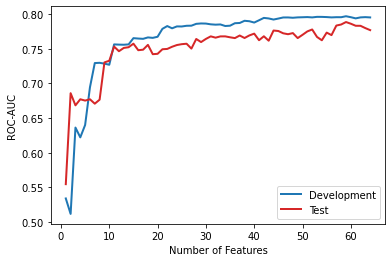

In [14]:
test_auroc_list = []
for topK in tqdm(range(1,max_n_features+1)):
    x_cols = list(df_imp[:topK].col.values)
    X, X_test = median_imputation(df[x_cols].values, df_test[x_cols].values) # imputation
    final_res_lr = bootstrap_LR(X, y, X_test, y_test, x_cols) # LR best
    test_auroc_list.append(final_res_lr['auroc'])

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
plt.xlabel('Number of Features')
plt.ylabel('ROC-AUC')
ax.plot(list(range(1,max_n_features+1)), res_df.AUROC_mean.values, label='Development', color='tab:blue', linewidth=2)
ax.plot(list(range(1,max_n_features+1)), test_auroc_list, label='Test', color='tab:red', linewidth=2)
plt.legend(fontsize=10)
